## This is my attempt at implementing the RouBl algorithm

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

In [28]:
class FullCovGaussianLinear(nn.Module):
    """Applies a linear transformation to the incoming data: y = xW^T + b, where
    the weight W and bias b are sampled from the q distribution.
    """

    def __init__(self, dim_in, dim_out, prior_weight_std=1.0, prior_bias_std=1.0, init_std=0.05,
                 sqrt_width_scaling=False, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(FullCovGaussianLinear, self).__init__()
        self.dim_in = dim_in  # dimension of network layer input
        self.dim_out = dim_out  # dimension of network layer output

        # define the trainable variational parameters for q distribtuion
        # first define and initialise the mean parameters
        self.weight_mean = nn.Parameter(torch.empty((dim_out, dim_in), **factory_kwargs))
        self.bias_mean = nn.Parameter(torch.empty(dim_out, **factory_kwargs))

        num_params = dim_out * dim_in + dim_out # total number of parameters
        self._cov_diag = nn.Parameter(torch.empty((num_params,), **factory_kwargs))
        self._cov_tril = nn.Parameter(torch.empty((num_params, num_params), **factory_kwargs))
        
        self.reset_parameters(init_std)

        # define the prior parameters (for prior p, assume the mean is 0)
        prior_mean = 0.0
        if sqrt_width_scaling:  # prior variance scales as 1/dim_in
            prior_weight_std /= self.dim_in ** 0.5
        self.prior_weight_std = prior_weight_std
        self.prior_bias_std = prior_bias_std
        # prior parameters are registered as constants
        self.register_buffer("prior_mean", torch.full((num_params,), prior_mean, **factory_kwargs))
        prior_weight_std = torch.full_like(self.weight_mean, prior_weight_std)
        prior_bias_std = torch.full_like(self.bias_mean, prior_bias_std)
        prior_std_diag = torch.concat((prior_weight_std.flatten(), prior_bias_std.flatten()))
        self.register_buffer('prior_scale_tril', prior_std_diag.diag_embed())


    def reset_parameters(self, init_std=0.5):
        nn.init.kaiming_uniform_(self.weight_mean, a=math.sqrt(5))
        bound = self.dim_in ** -0.5
        nn.init.uniform_(self.bias_mean, -bound, bound)
        _init_std_param = math.log(math.expm1(init_std))
        self._cov_diag.data = torch.full_like(self._cov_diag.data, _init_std_param)
        self._cov_tril.data = torch.full_like(self._cov_tril.data, 0.0)

    # define the q distribution standard deviations with property decorator#
    @property
    def mean(self):
        # flatten the weight matrix into a vector
        return torch.concat((self.weight_mean.flatten(), self.bias_mean.flatten()))

    @property
    def scale_tril(self):
        # this returns the cholesky decomposition L of the covariance: Cov = LL^T
        
        # Only taking values below the main diagonal? no it takes everything below diagonal
        return F.softplus(self._cov_diag).diagflat() + torch.tril(self._cov_tril, diagonal=-1)


    # KL divergence KL[q||p] between two Gaussians
    def kl_divergence(self):
        q = dist.MultivariateNormal(self.mean, scale_tril=self.scale_tril)
        p = dist.MultivariateNormal(self.prior_mean, scale_tril=self.prior_scale_tril)
        kl = dist.kl_divergence(q, p).sum()
        return kl

     # forward pass with Monte Carlo (MC) sampling
    def forward(self, input):
        weight, bias = self._normal_sample(self.mean, self.scale_tril)
        return F.linear(input, weight, bias)

    def _normal_sample(self, mean, scale_tril):
        sample = mean + scale_tril @ torch.randn_like(mean)
        # chunk out the weight and bias
        weight_vec, bias = torch.split(sample, [self.dim_in * self.dim_out, self.dim_out])
        return weight_vec.reshape(self.dim_out, self.dim_in), bias

# construct a BNN
def make_full_bnn(layer_sizes, activation='LeakyReLU', **layer_kwargs):
    nonlinearity = getattr(nn, activation)() if isinstance(activation, str) else activation
    net = nn.Sequential()

    for i, (dim_in, dim_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        net.add_module(f'FullCovGaussianLinear{i}', FullCovGaussianLinear(dim_in, dim_out, **layer_kwargs))
        if i < len(layer_sizes) - 2:
            net.add_module(f'Nonlinarity{i}', nonlinearity)
            
    return net

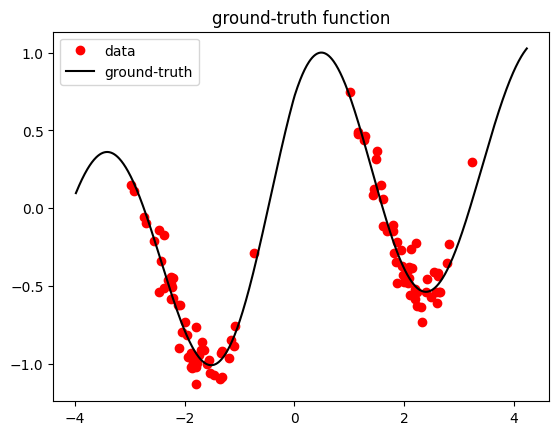

In [29]:
def ground_truth_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x

def gen_data(N_data, ground_truth_func, noise_std=None):
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)
dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# plot the training data and ground truth
x_test = np.arange(np.min(x_train) - 1.0, np.max(x_train)+1.0, 0.01)[:, np.newaxis]
y_test = ground_truth_func(x_test)
plt.plot(x_train, y_train, 'ro', label='data')
plt.plot(x_test, y_test, 'k-', label='ground-truth')
plt.legend()
plt.title('ground-truth function')
plt.show()

In [27]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
x_dim, y_dim = x_train.shape[1], y_train.shape[1]
# build a BNN, with hidden layer width = h_dim
h_dim = 50
layer_sizes = [x_dim, h_dim, h_dim, y_dim]
# you can change the activation function here or define your own customized activation
# activation=nn.GELU()
activation = nn.LeakyReLU(negative_slope=0.01)
# you can change the prior parameters as you wish
layer_kwargs = {'prior_weight_std': 1.0,
                'prior_bias_std': 1.0,
                'sqrt_width_scaling': False,
                'init_std': 0.05,
                'device': device}

full_regression_net = make_full_bnn(layer_sizes, activation=activation, **layer_kwargs) ## I commented this in



# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)
# print out the BNN settings
print("BNN architecture: \n", full_regression_net) ## and trhi

BNN architecture: 
 Sequential(
  (FullCovGaussianLinear0): FullCovGaussianLinear()
  (Nonlinarity0): LeakyReLU(negative_slope=0.01)
  (FullCovGaussianLinear1): FullCovGaussianLinear()
  (Nonlinarity1): LeakyReLU(negative_slope=0.01)
  (FullCovGaussianLinear2): FullCovGaussianLinear()
)


ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions

## Just trying to do it raw